In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
from io import BytesIO
from functools import partial
import keras
import keras.backend as K
import PIL.Image
import keras.layers
from IPython.display import clear_output

c:\anaconda\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 1. Load images A (background) and B (foregound object) with the same size
# 2. Build laplacian pyramid PA and PB for images A and B respectively
# 3. Reconstruct A, reconstruct B

with open(os.path.join('D:/Research/LayeredEmbeddings/val_set', 'example_000000003156_and_000000009448_full.pickle'), 'rb') as file:
    C = pickle.load(file)

dict_keys(['pixelid', 'inserted', 'A', 'occ_mask', 'masks', 'image_scaled_and_padded', 'masks_small', 'y', 'B_dominant_person', 'y_training_enable_mask', 'B', 'B_dominant_person_mask'])


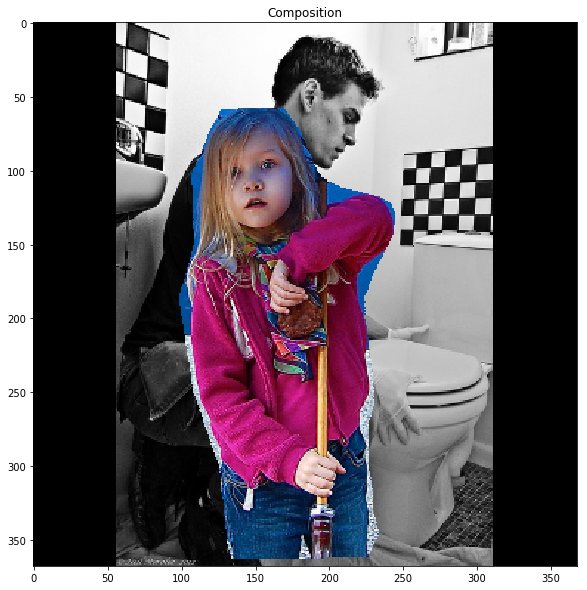

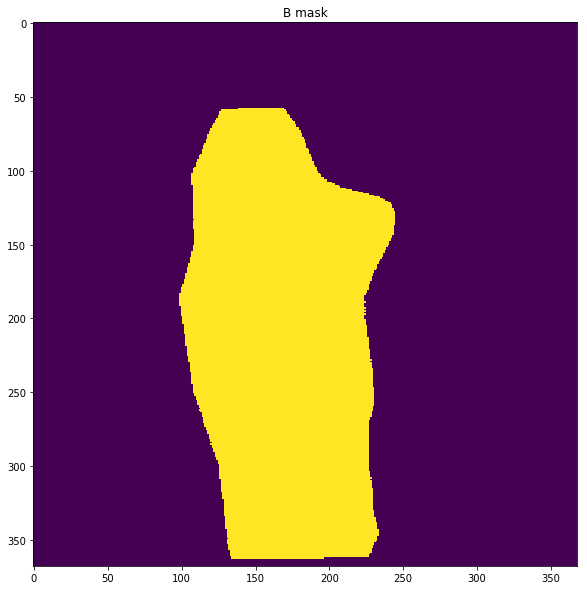

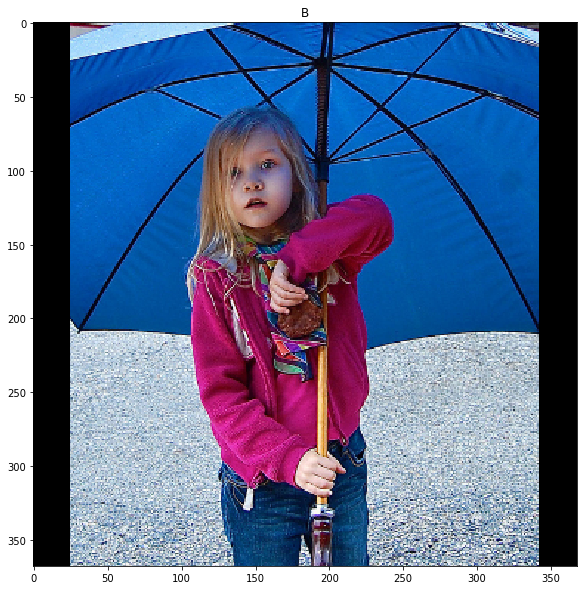

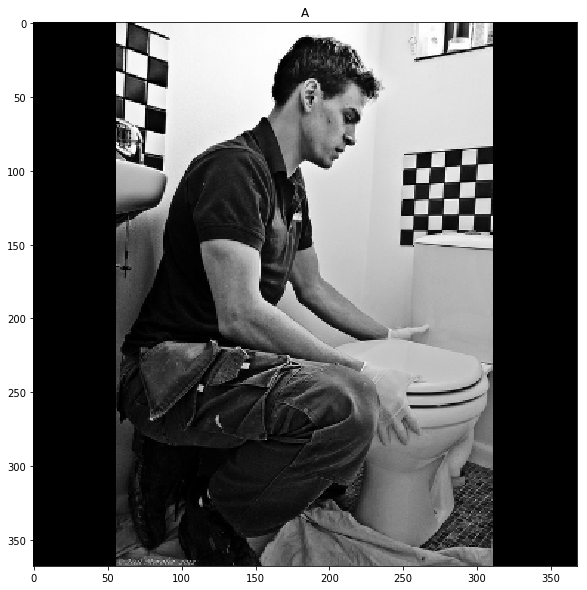

In [306]:
print(C.keys())
plt.figure(figsize=(10,10))
plt.imshow(C['image_scaled_and_padded'].astype(np.uint8))
plt.title('Composition')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(C['B_dominant_person_mask'])
plt.title('B mask')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(C['B']['image_scaled_and_padded'].astype(np.uint8))
plt.title('B')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(C['A']['image_scaled_and_padded'].astype(np.uint8))
plt.title('A')
plt.show()

A = C['A']['image_scaled_and_padded']
B = C['B']['image_scaled_and_padded']
M = C['B_dominant_person_mask']>0



In [8]:
k = np.float64([1,4,6,4,1])
k = np.outer(k, k)
print(k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

[[ 1.  4.  6.  4.  1.]
 [ 4. 16. 24. 16.  4.]
 [ 6. 24. 36. 24.  6.]
 [ 4. 16. 24. 16.  4.]
 [ 1.  4.  6.  4.  1.]]


In [284]:
def lap_split(img, name:str='split'):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope(name):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n:int, name:str='pyramid') -> list:
    with tf.name_scope(name):
        pyr = []
        for i in range(0, n):
            img, hi = lap_split( img, name='split{}'.format(i) )
            pyr.append(hi)
        pyr.append(img)
        return pyr[::-1] # reverse the order
    
def lap_combine(levels:list):
    levels_out =[  ]
    img = levels[0]
    for i in range(1, len(levels)):
        hi = levels[i]
        img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
        levels_out.append( img )
    return img, levels_out

def lap_combine_two(levels_A:list, levels_B:list, mask):
    with tf.variable_scope('reconstruction'):
        levels_out = []
        img_A = levels_A[0]
        img_B = levels_B[0]
        n = len(levels_A)
        step = np.power(2,n-1)
        
#        m = tf.nn.conv2d(np.expand_dims(np.stack(3*[mask], axis=2).astype(np.float64),0), k5x5, [1,2,2,1], 'SAME')
#        m = tf.nn.conv2d(m, k5x5, [1,2,2,1], 'SAME')
#        m = tf.nn.conv2d(m, k5x5, [1,2,2,1], 'SAME')
#        m = tf.nn.conv2d(m, k5x5, [1,2,2,1], 'SAME')
        m = tf.convert_to_tensor(np.stack(3*[mask[::step, ::step]], axis=2), dtype=tf.float64, name='mask0')
#        m = tf.convert_to_tensor(   cv2.resize(np.stack(3*[mask], axis=2).astype(np.uint8), (mask.shape[0]//step, mask.shape[1]//step))   , dtype=tf.float64, name='mask0')
        
        img = tf.multiply( img_A, 1-m ) + tf.multiply(img_B, m)
        levels_out.append(img)
        
        for i in range(1, len(levels_A)):
            step = np.power(2,n-i-1)
            m = tf.convert_to_tensor(np.stack(3*[mask[::step,::step]], axis=2), dtype=tf.float64, name='mask{}'.format(i))
#            m = tf.convert_to_tensor(   cv2.resize(np.stack(3*[mask], axis=2).astype(np.uint8), (mask.shape[0]//step, mask.shape[1]//step)), dtype=tf.float64, name='mask{}'.format(i))
            print(m)
#            print(img_A)
            hi = tf.multiply( levels_A[i], 1-m ) + tf.multiply( levels_B[i], m )
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
            levels_out.append(img)
            # SELECTIVE MASKING
        return tf.clip_by_value(img, 0, 255), levels_out
    
levels_A = lap_split_n(np.expand_dims(A,0), 4)
levels_B = lap_split_n(np.expand_dims(B,0),4)

rec = lap_combine_two( levels_A, levels_B, M )

Tensor("reconstruction_81/mask1:0", shape=(46, 46, 3), dtype=float64)
Tensor("reconstruction_81/mask2:0", shape=(92, 92, 3), dtype=float64)
Tensor("reconstruction_81/mask3:0", shape=(184, 184, 3), dtype=float64)
Tensor("reconstruction_81/mask4:0", shape=(368, 368, 3), dtype=float64)


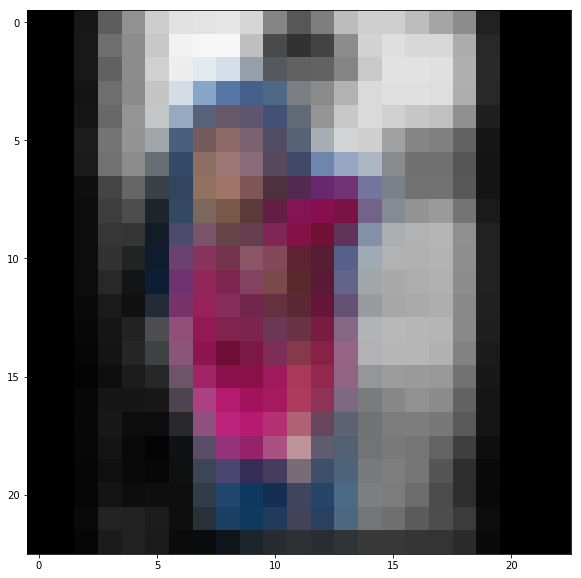

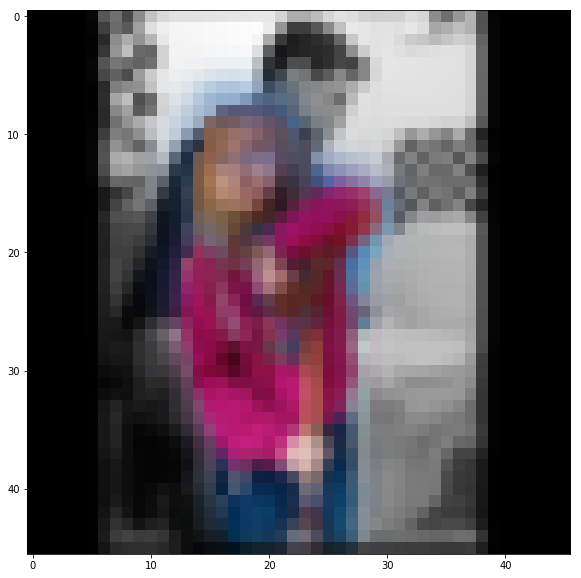

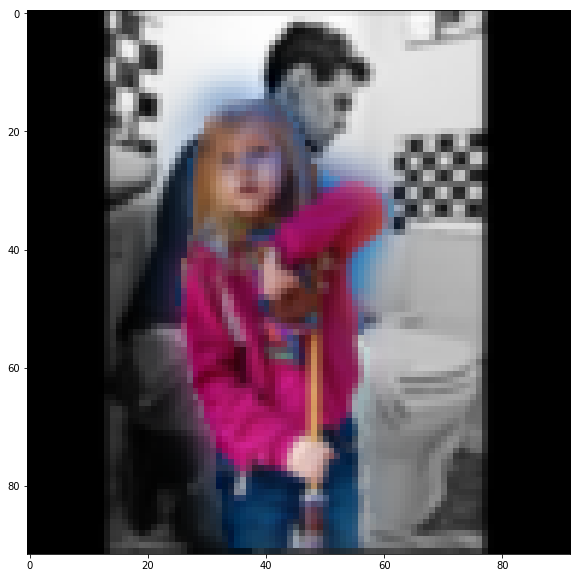

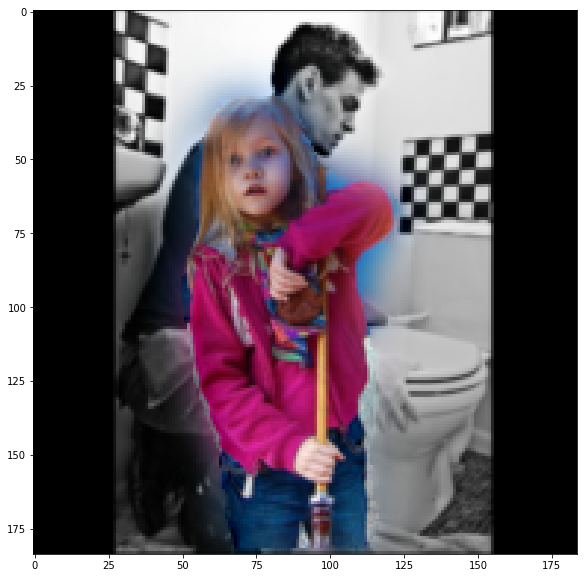

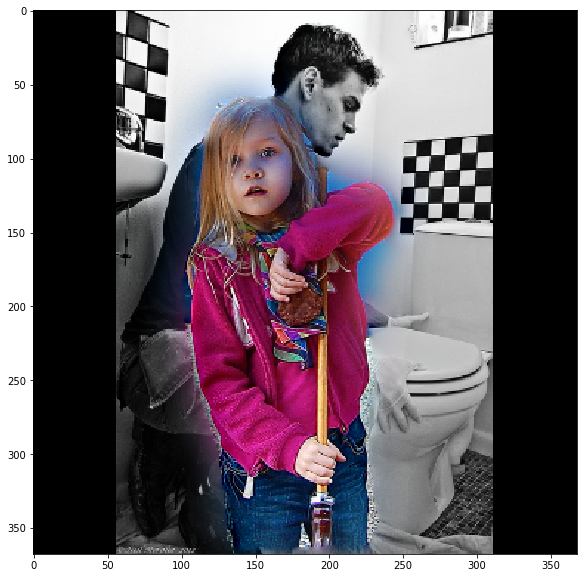

In [271]:
for img in out[1]:
    plt.figure(figsize=(10,10))
    plt.imshow(np.clip(img[0], 0,255).astype(np.uint8))
    plt.show()

In [285]:
with tf.Session() as sess:
    out = sess.run(rec)


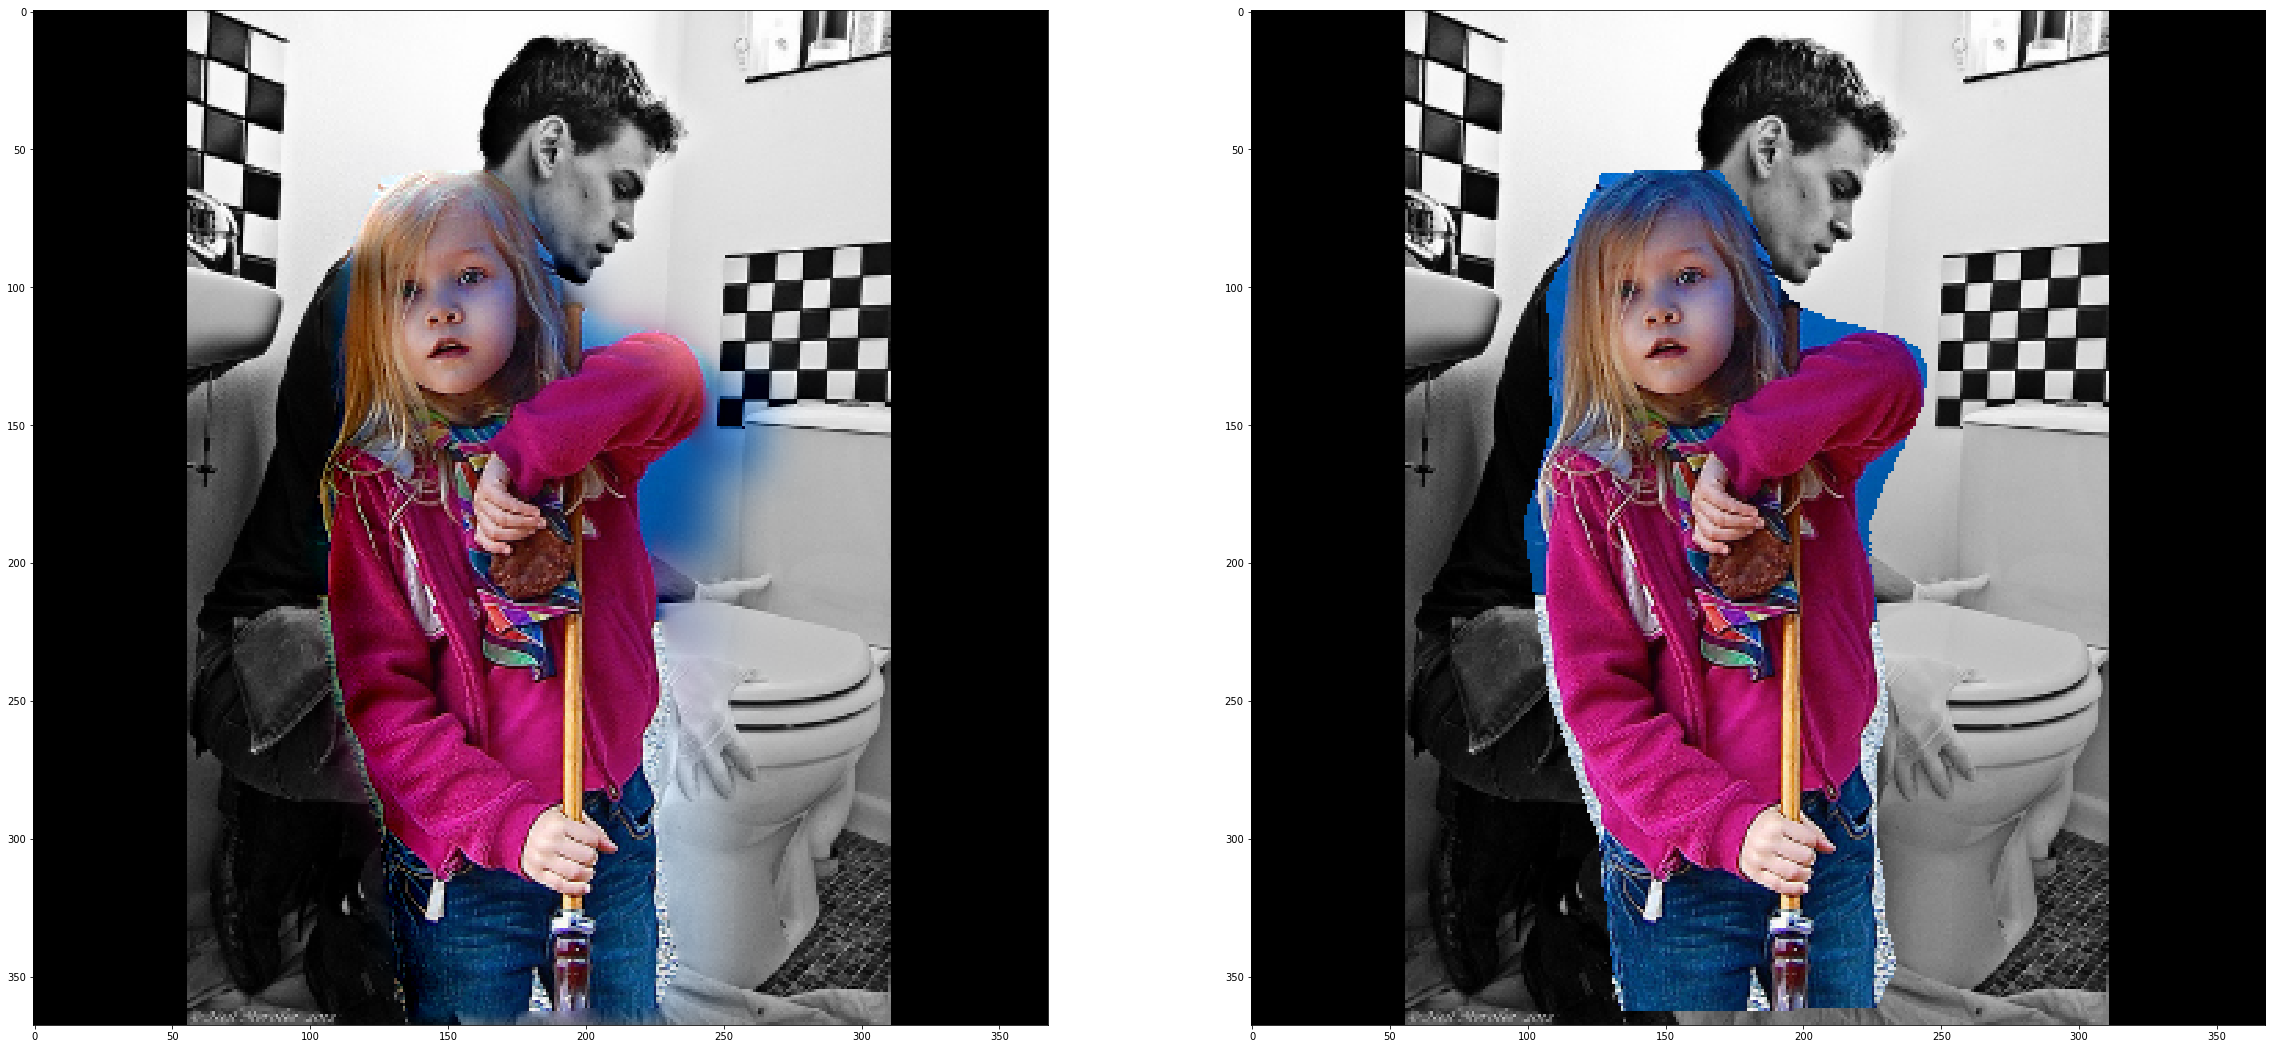

In [303]:
    

plt.figure(figsize=(40,20))
plt.subplot(1,2,1)
plt.imshow(out[0][0].astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(C['image_scaled_and_padded'].astype(np.uint8))
plt.show()

(368, 368, 3)


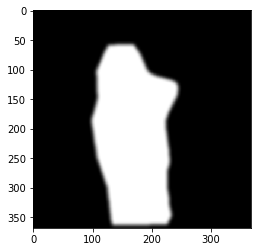

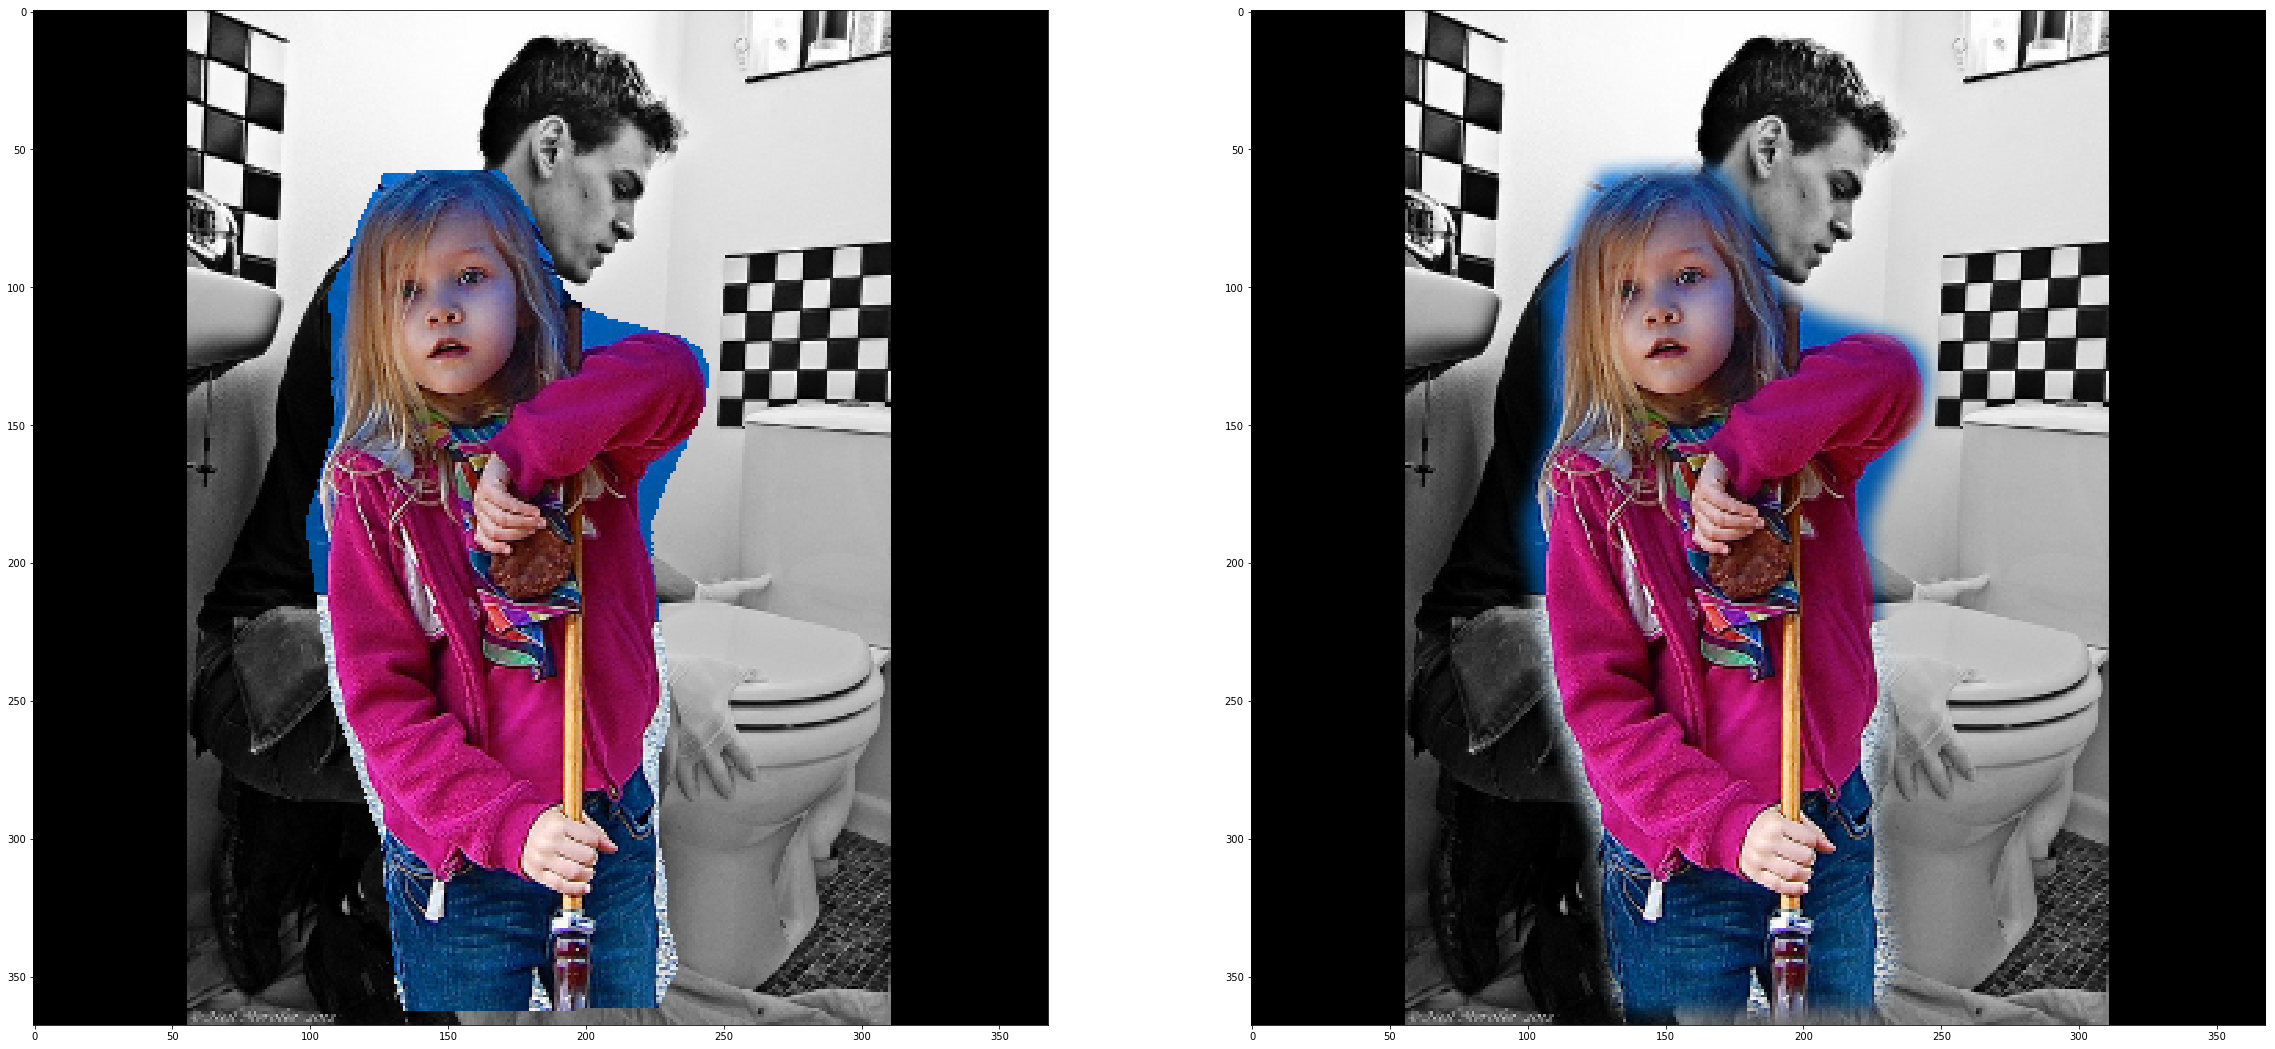

In [305]:
mask = np.stack([  C['B_dominant_person_mask']>0   ]*3, axis=2).astype(np.uint8)

print(mask.shape)

kernel = np.ones((7,7),np.float32)/49
mask_gaussian = cv2.filter2D(mask*255,-1,kernel)
mask_gaussian = cv2.filter2D(mask_gaussian,-1,kernel)
#mask_gaussian = cv2.filter2D(mask_gaussian,-1,kernel)
#mask_gaussian = cv2.filter2D(mask_gaussian,-1,kernel)
#mask_gaussian = cv2.filter2D(mask_gaussian,-1,kernel)
#mask_gaussian = cv2.filter2D(mask_gaussian,-1,kernel)
#mask_gaussian = cv2.filter2D(mask_gaussian,-1,kernel)
#mask_gaussian = cv2.filter2D(mask_gaussian,-1,kernel)
mask_gaussian = mask_gaussian/255;
plt.imshow(mask_gaussian)
plt.show()

def get_naive_composition(C, mask):
    img = np.multiply(C['A']['image_scaled_and_padded'], 1-mask) + np.multiply(C['B']['image_scaled_and_padded'], mask)
    plt.imshow(img.astype(np.uint8))
    
plt.figure(figsize=(40,20))
plt.subplot(1,2,1)
get_naive_composition(C, mask)
plt.subplot(1,2,2)
get_naive_composition(C, mask_gaussian)
plt.show()

In [274]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    pyr_A, pyr_B = sess.run([ levels_A, levels_B ])

In [257]:
def show_levels(levels:list, save_folder=None, prefix='level'):
    for i in range(0, len(levels)):
        plt.imshow( levels[i][0].astype(np.uint8) )
        plt.title('{}_{}'.format(prefix,i))
        plt.show()
        
        if save_folder is not None:
            fpath = os.path.join(save_folder, '{}_{}.png'.format(prefix, i))
            cv2.imwrite( fpath, cv2.cvtColor(levels[i][0].astype(np.uint8), cv2.COLOR_RGB2BGR) )

In [83]:
print(len(pyr_A))

4


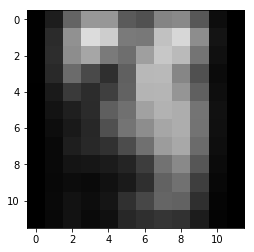

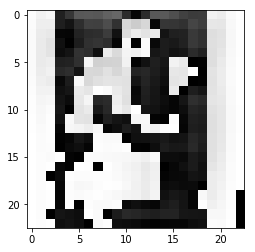

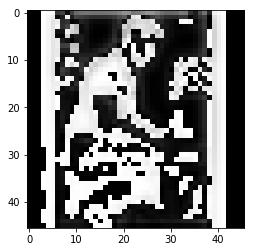

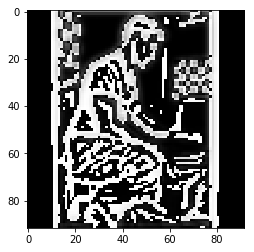

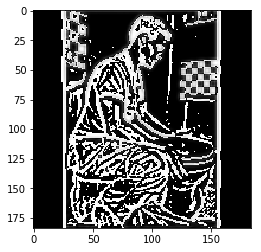

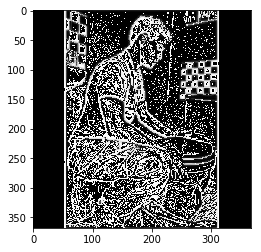

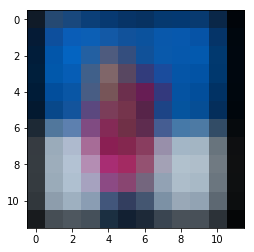

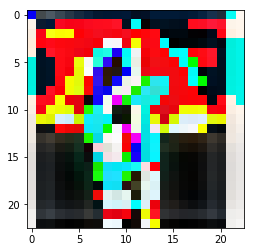

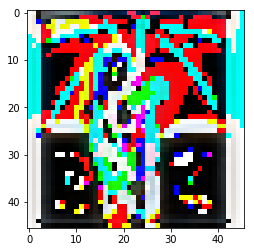

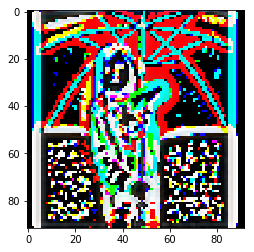

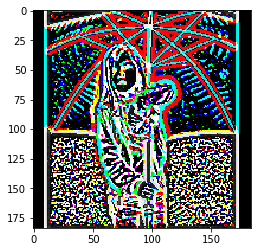

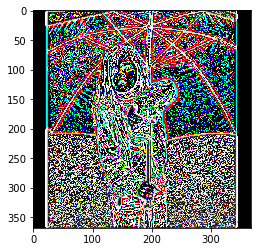

In [246]:
show_levels(pyr_A, './')
show_levels(pyr_B, './')


In [255]:
levels_A_tensor = lap_split_n(np.expand_dims(B,0), 4)
rec_A_tensor = lap_combine(levels_A_tensor)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    levels_A =  sess.run(levels_A_tensor )
    rec_A = sess.run(rec_A_tensor)
    

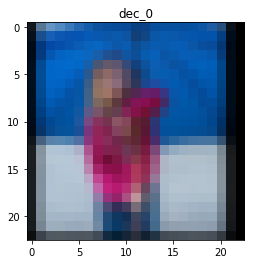

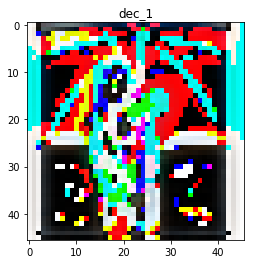

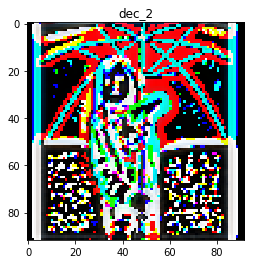

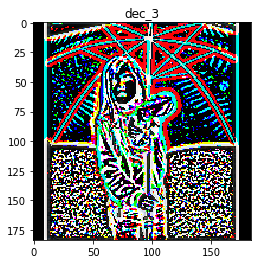

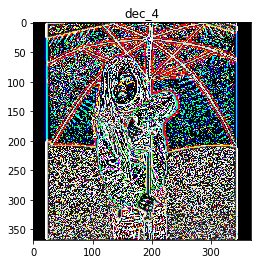

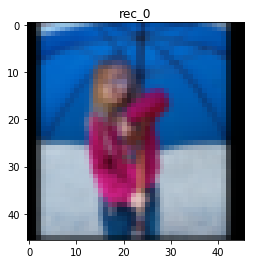

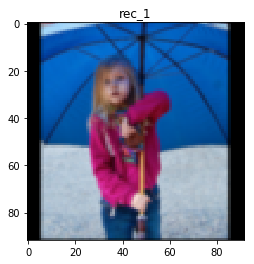

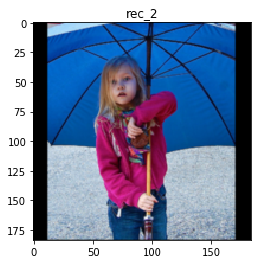

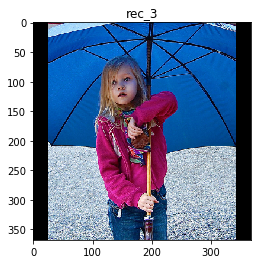

In [258]:
show_levels(levels_A, './', 'dec')
show_levels(rec_A[1], './', 'rec')


In [261]:
print(C['B']['img_info'])

{'coco_url': 'http://images.cocodataset.org/val2017/000000009448.jpg', 'flickr_url': 'http://farm6.staticflickr.com/5255/5389014889_0c50cf03cf_z.jpg', 'file_name': '000000009448.jpg', 'height': 640, 'width': 551, 'local_path': 'd:/Datasets/COCO\\val2017\\000000009448.jpg', 'date_captured': '2013-11-18 11:35:31', 'id': 9448, 'license': 2}
